In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from humanize import naturaldelta
from matplotlib.patches import Patch

sys.path.insert(0, "..")
from runner.utils import (
    allocate_benchmarks,
    create_benchmark_campaign,
    load_benchmark_metadata,
)

In [2]:
# If a util function was modified, use this cell to reload it without having to restart the kernel
%run ../runner/utils.py

### Util to load results from older runs

In [3]:
# Use this function for 20251128 and 20251201 since those runs were before we started recording `VM Zone`, which is required by utils.load_results
def load_results(folder: str | list[str]):
    """Loads all CSV files in `folder`. Returns the results and variability dataframes."""
    folders = folder if isinstance(folder, list) else [folder]
    csv_files = [p for f in folders for p in Path(f).glob("*.csv")]
    results = pd.concat([pd.read_csv(p) for p in csv_files]).reset_index(drop=True)

    # Remove reference benchmark
    reference_results = results.query('Benchmark == "reference-benchmark"')
    results = results.query('Benchmark != "reference-benchmark"').copy()

    # Find the variability of each VM
    variability = reference_results.groupby(["Hostname", "Run ID"]).agg(
        {"Runtime (s)": ["count", "min", "max", "std", "mean"]}
    )
    variability["std %"] = (
        variability[("Runtime (s)", "std")] * 100 / variability[("Runtime (s)", "mean")]
    )

    # Print some basic stats
    results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
    results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]
    print(
        f"Found {len(results)} records, {len(results['bench-size'].unique())} benchmark instances"
    )
    return results, variability

## Setup benchmark campaign

### 20251128 Test HiPO on paper's PyPSA instances

In [4]:
urls = """https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-10-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-10-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-10-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-10-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-2-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-2-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-2-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-2-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-3-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-3-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-3-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-3-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-4-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-4-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-4-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-4-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-5-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-5-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-5-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-5-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-6-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-6-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-6-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-6-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-7-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-7-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-7-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-7-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-8-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-8-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-8-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-8-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-9-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-9-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-9-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-9-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-10-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-10-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-10-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-10-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-2-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-2-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-2-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-2-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-3-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-3-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-3-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-3-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-4-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-4-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-4-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-4-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-5-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-5-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-5-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-5-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-6-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-6-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-6-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-6-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-7-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-7-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-7-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-7-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-8-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-8-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-8-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-8-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-9-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-9-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-9-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-9-3h.lp"""

benchmarks = {}
for url in urls.strip().split("\n"):
    # Extract filename from URL
    filename = url.split("/")[-1].replace(".lp", "")
    # Parse benchmark name and size (first 4 parts as benchmark name, rest as size name)
    parts = filename.split("-")
    if len(parts) >= 5:
        key = "-".join(parts[:4])
        name = "-".join(parts[4:])
        if key not in benchmarks:
            benchmarks[filename] = {"Sizes": []}
        benchmarks[filename]["Sizes"].append({"Name": name, "Size": None, "URL": url})

# Write to yaml file
with open("../pypsa-hipo-benchmarks.yaml", "w") as f:
    yaml.dump({"benchmarks": benchmarks}, f, default_flow_style=False, sort_keys=False)

In [5]:
with open("../pypsa-hipo-benchmarks.yaml", "r") as f:
    hipo_benchmarks = yaml.safe_load(f)

In [6]:
def get_machine_type(size):
    return "c4-highmem-8" if size == "L" else "c4-standard-2"

In [13]:
# Create hipo benchmarks

# Create output directory for HIPO benchmarks
hipo_output_dir = Path("../infrastructure/benchmarks/20251128-test-hipo")
hipo_output_dir.mkdir(parents=True, exist_ok=True)

# Check for existing yaml files and clean them up
existing_files = list(hipo_output_dir.glob("*.yaml"))
if existing_files:
    print(f"Warning: Found {len(existing_files)} existing yaml files in {hipo_output_dir}")
    for f in existing_files:
        f.unlink()
    print("Cleaned up existing files.")

# Pick the largest 4 instances of each bench
# Filter pypsa-eur-elec-op
op_df = hipo_benchmarks[hipo_benchmarks["Benchmark"].str.startswith("pypsa-eur-elec-op")]
op_df = op_df.sort_values("Num. variables").tail(4)

# Convert to list of (name, record) pairs
op_benchs = [
    (row.Benchmark, row) for _, row in op_df.iterrows()
]

# Same for trex
tr_df = hipo_benchmarks[hipo_benchmarks["Benchmark"].str.startswith("pypsa-eur-elec-trex")]
tr_df = tr_df.sort_values("Num. variables").tail(4)
tr_benchs = [
    (row.Benchmark, row) for _, row in tr_df.iterrows()
]

# Generate YAML files
hipo_idx = 0
for benchmark_name, row in op_benchs + tr_benchs:
    # Remove size suffix from benchmark name
    benchmark_base = "-".join(benchmark_name.split("-")[:-2])

    size_data = {
        "Name": row.Instance,
        "Size": row["Size"],
        "URL": row["URL"]
    }

    output_filename = f"{hipo_idx:02d}-pypsa-hipo.yaml"
    output_path = hipo_output_dir / output_filename

    output_yaml = {
        "machine-type": get_machine_type(row["Size"]),
        "zone": "us-central1-a",
        "years": [2025],
        "solver": "highs-hipo-ipm highs-hipo-64 highs-hipo-no2hop",
        "benchmarks": {
            benchmark_base: {
                "Sizes": [size_data]
            }
        },
    }

    with open(output_path, "w") as f:
        yaml.dump(output_yaml, f, default_flow_style=False, sort_keys=False)

    print(f"Created: {output_filename}")
    hipo_idx += 1

print(f"\nTotal HIPO files created: {len(list(hipo_output_dir.glob('*.yaml')))}")


Created: 00-pypsa-hipo.yaml
Created: 01-pypsa-hipo.yaml
Created: 02-pypsa-hipo.yaml
Created: 03-pypsa-hipo.yaml

Total HIPO files created: 4


In [14]:
with open("../pypsa-hipo-benchmarks.yaml", "r") as f:
    hipo_benchmarks = yaml.safe_load(f)

### 20251201 Test new large PyPSA instances

In [15]:
# Load the new benchmarks
with open("../benchmarks/pypsa/metadata_new_pypsa_benchmarks.yaml", "r") as f:
    new_benchmarks = yaml.safe_load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../benchmarks/pypsa/metadata_new_pypsa_benchmarks.yaml'

In [16]:
# Create benchmark campaign
output_dir = Path("../infrastructure/benchmarks/20251201-hipo-new-pypsa")
output_dir.mkdir(parents=True, exist_ok=True)


# Determine machine type and solvers based on size and problem class
def get_machine_type(size):
    return "c4-highmem-8" if size == "L" else "c4-standard-2"


idx = 0
for benchmark_name, benchmark_data in new_benchmarks["benchmarks"].items():
    for size_data in benchmark_data.get("Sizes", []):
        size = size_data["Size"]

        output_filename = f"{idx:02d}-hipo-new-pypsa.yaml"
        output_path = output_dir / output_filename
        output_yaml = {
            "machine-type": get_machine_type(size),
            "zone": "us-central1-a",
            "years": [2025],
            "solver": "gurobi highs-hipo-no2hop highs-hipo-64 highs-hipo-ipm",
            "timeout_seconds": 24 * 60 * 60,
            "benchmarks": {
                benchmark_name: {
                    "Sizes": [
                        {
                            "Name": size_data["Name"],
                            "Size": size,
                            "URL": size_data["URL"],
                        }
                    ]
                }
            },
        }

        with open(output_path, "w") as f:
            yaml.dump(output_yaml, f, default_flow_style=False, sort_keys=False)
        print(f"Created: {output_filename}")
        idx += 1

print(f"\nTotal files created: {len(list(output_dir.glob('*.yaml')))}")

NameError: name 'new_benchmarks' is not defined

In [17]:
num_vars_and_bench = []
for bench, meta in new_benchmarks["benchmarks"].items():
    for size in meta["Sizes"]:
        num_vars_and_bench.append((size["Num. variables"], f"{bench}-{size['Name']}"))
for num_vs, bench in sorted(num_vars_and_bench):
    print(f"{bench}: {num_vs:,.0f}")

NameError: name 'new_benchmarks' is not defined

In [18]:
# Check the results manually (can't use utils.load_results because this run didn't record `VM Zone1`)
csv_files = [
    p for p in Path("../results/gcp-results/20251201-hipo-new-pypsa/").glob("*.csv")
]
results = pd.concat([pd.read_csv(p) for p in csv_files]).reset_index(drop=True)
reference_results = results.query('Benchmark == "reference-benchmark"')
results = results.query('Benchmark != "reference-benchmark"').copy()
results

/tmp/ipykernel_21078/3486318512.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([pd.read_csv(p) for p in csv_files]).reset_index(drop=True)


,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
0,pypsa-eur-elec-trex_vopt,50-1h,gurobi,12.0.3,2025.0,TO,Timeout,86400.000000,30807.732,NaN,NaN,NaN,86400.000000,86400.0,benchmark-instance-04-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:19:33.382964
2,pypsa-eur-sec-trex_vopt,50-1h,gurobi,12.0.3,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-00-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:22:49.404869
4,pypsa-eur-sec-trex_vopt,50-1h,highs-hipo-no2hop,1.12.0-hipo,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-00-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:32:01.479494
5,pypsa-eur-sec-trex_vopt,50-1h,highs-hipo-64,1.12.0-hipo,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-00-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:35:51.116007
6,pypsa-eur-sec-trex_vopt,50-1h,highs-hipo-ipm,1.12.0-hipo,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-00-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:36:06.438968
7,pypsa-eur-sec-trex_vopt,50-3h,gurobi,12.0.3,2025.0,TO,Timeout,86400.000000,48765.440,NaN,NaN,NaN,86400.000000,86400.0,benchmark-instance-01-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:19:46.293980
9,pypsa-eur-elec-trex_vopt,50-3h,gurobi,12.0.3,2025.0,ok,optimal,12590.782178,16082.528,3.532154e+10,NaN,NaN,12548.509729,86400.0,benchmark-instance-05-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:18:34.272268
11,pypsa-eur-elec-trex_vopt,50-3h,highs-hipo-no2hop,1.12.0-hipo,2025.0,ok,Optimal,75187.224187,13072.440,3.532154e+10,NaN,NaN,75187.224187,86400.0,benchmark-instance-05-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 11:53:08.144692
13,pypsa-eur-elec-trex_vopt,50-3h,highs-hipo-64,1.12.0-hipo,2025.0,TO,Timeout,86400.000000,164.716,NaN,NaN,NaN,86400.000000,86400.0,benchmark-instance-05-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-02 08:49:55.443662
15,pypsa-eur-elec-trex_vopt,100-1h,gurobi,12.0.3,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-06-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:20:29.468980


Conclusion: most of these are too large! I killed the running VMs so as to not waste compute.

### 20251219 Run all sizes of a new PyPSA bench
Goal: to get a sense of which sizes are solvable

In [19]:
new_pypsa_benchs = load_benchmark_metadata("../benchmarks/pypsa/metadata.yaml")

In [20]:
# Run all de-elec instances > 5e5
to_run = new_pypsa_benchs.query(
    'Benchmark == "pypsa-de-elec" and `Num. variables` > 100000'
)
vm_yamls = allocate_benchmarks(
    to_run, "Num. variables", 11, machine_type="c4-highmem-8"
)  # 1 per VM

Allocated. Estimated runtime: 2399.4h
  VM 00: 1 instances, 2399.4h
  VM 01: 1 instances, 1070.7h
  VM 02: 1 instances, 799.9h
  VM 03: 1 instances, 586.5h
  VM 04: 1 instances, 356.9h
  VM 05: 1 instances, 200.1h
  VM 06: 1 instances, 195.5h
  VM 07: 1 instances, 100.1h
  VM 08: 1 instances, 89.3h
  VM 09: 1 instances, 48.9h
  VM 10: 1 instances, 44.7h


In [21]:
# Only run latest highs variants
for y in vm_yamls:
    y["years"] = [2025]
    y["solver"] = "highs-hipo highs-ipm highs"
create_benchmark_campaign("20251219-pypsa-sizes", "pypsa-sizes", vm_yamls)

Created directory and files in ../infrastructure/benchmarks/20251219-pypsa-sizes
Run this campaign from the infrastructure/ directory using the command:
tofu apply -var-file benchmarks/20251219-pypsa-sizes/run.tfvars -state=states/20251219-pypsa-sizes.tfstate


## Download logs & Results

Results were downloaded by running the following command on the root directory of this repository:
```
gsutil -m rsync -r gs://solver-benchmarks/logs ./runner/logs/ && gsutil -m rsync -r gs://solver-benchmarks-restricted/logs ./runner/logs/  && gsutil -m rsync -r gs://solver-benchmarks/results ./results/gcp-results/
```
Then, the cells in the next section were run to clean, check, and analyze results.

## Analyze Results

In [22]:
# results, variability = load_results(['../results/gcp-results/20251128-test-hipo/', '../results/gcp-results/20251219-pypsa-sizes/'])
results, variability = load_results("../results/gcp-results/20251219-pypsa-sizes/")

Found 33 records, 11 benchmark instances


### Check runtime variability

In [23]:
variability.sort_values(by="std %", ascending=False)

Runtime (s)  \
                                                             count   
Hostname                          Run ID                             
benchmark-instance-pypsa-sizes-00 20251219-pypsa-sizes           3   
benchmark-instance-pypsa-sizes-03 20251219-pypsa-sizes           3   
benchmark-instance-pypsa-sizes-01 20251219-pypsa-sizes           3   
benchmark-instance-pypsa-sizes-05 20251219-pypsa-sizes           2   
benchmark-instance-pypsa-sizes-07 20251219-pypsa-sizes           2   
benchmark-instance-pypsa-sizes-04 20251219-pypsa-sizes           3   
benchmark-instance-pypsa-sizes-02 20251219-pypsa-sizes           3   
benchmark-instance-pypsa-sizes-06 20251219-pypsa-sizes           2   
benchmark-instance-pypsa-sizes-08 20251219-pypsa-sizes           1   
benchmark-instance-pypsa-sizes-09 20251219-pypsa-sizes           1   
benchmark-instance-pypsa-sizes-10 20251219-pypsa-sizes           1   

                                                                    \
                                                               min   
Hostname                          Run ID                             
benchmark-instance-pypsa-sizes-00 20251219-pypsa-sizes  191.973973   
benchmark-instance-pypsa-sizes-03 20251219-pypsa-sizes  205.313075   
benchmark-instance-pypsa-sizes-01 20251219-pypsa-sizes  203.779731   
benchmark-instance-pypsa-sizes-05 20251219-pypsa-sizes  213.517188   
benchmark-instance-pypsa-sizes-07 20251219-pypsa-sizes  211.459494   
benchmark-instance-pypsa-sizes-04 20251219-pypsa-sizes  208.494510   
benchmark-instance-pypsa-sizes-02 20251219-pypsa-sizes  217.810332   
benchmark-instance-pypsa-sizes-06 20251219-pypsa-sizes  237.979433   
benchmark-instance-pypsa-sizes-08 20251219-pypsa-sizes  223.262342   
benchmark-instance-pypsa-sizes-09 20251219-pypsa-sizes  221.899480   
benchmark-instance-pypsa-sizes-10 20251219-pypsa-sizes  227.473434   

                                                                               \
                                                               max        std   
Hostname                          Run ID                                        
benchmark-instance-pypsa-sizes-00 20251219-pypsa-sizes  220.652830  16.554366   
benchmark-instance-pypsa-sizes-03 20251219-pypsa-sizes  232.593987  14.133740   
benchmark-instance-pypsa-sizes-01 20251219-pypsa-sizes  219.456557   8.857109   
benchmark-instance-pypsa-sizes-05 20251219-pypsa-sizes  220.382993   4.854857   
benchmark-instance-pypsa-sizes-07 20251219-pypsa-sizes  217.769141   4.461594   
benchmark-instance-pypsa-sizes-04 20251219-pypsa-sizes  215.229608   3.871871   
benchmark-instance-pypsa-sizes-02 20251219-pypsa-sizes  223.879810   3.218229   
benchmark-instance-pypsa-sizes-06 20251219-pypsa-sizes  242.284721   3.044298   
benchmark-instance-pypsa-sizes-08 20251219-pypsa-sizes  223.262342        NaN   
benchmark-instance-pypsa-sizes-09 20251219-pypsa-sizes  221.899480        NaN   
benchmark-instance-pypsa-sizes-10 20251219-pypsa-sizes  227.473434        NaN   

                                                                       std %  
                                                              mean            
Hostname                          Run ID                                      
benchmark-instance-pypsa-sizes-00 20251219-pypsa-sizes  211.089307  7.842352  
benchmark-instance-pypsa-sizes-03 20251219-pypsa-sizes  216.816511  6.518756  
benchmark-instance-pypsa-sizes-01 20251219-pypsa-sizes  209.237132  4.233048  
benchmark-instance-pypsa-sizes-05 20251219-pypsa-sizes  216.950091  2.237776  
benchmark-instance-pypsa-sizes-07 20251219-pypsa-sizes  214.614318  2.078889  
benchmark-instance-pypsa-sizes-04 20251219-pypsa-sizes  210.758881  1.837109  
benchmark-instance-pypsa-sizes-02 20251219-pypsa-sizes  221.463499  1.453165  
benchmark-instance-pypsa-sizes-06 20251219-pypsa-sizes  240.132077  1.267760  
benchmark-instance-pypsa-sizes-08 20251219-pypsa-sizes  223.262342       NaN  
benchmark-

### Check objective values

In [24]:
# Check that all solvers report similar objective values

# TODO glpk is being ignored here
# obj_dev = results[(~results['Objective Value'].isna())].groupby(['Benchmark', 'Size']).agg({'Objective Value': ['min', 'max', 'std']})
obj_dev = (
    results[(~results["Objective Value"].isna()) & (results["Solver"] != "glpk")]
    .groupby(["Benchmark", "Size"])
    .agg({"Objective Value": ["min", "max", "std"]})
)

obj_dev["std_ratio"] = (
    obj_dev[("Objective Value", "std")] / obj_dev[("Objective Value", "min")]
)
obj_dev[~obj_dev["std_ratio"].isna()].sort_values(by="std_ratio").tail()

Objective Value                          \
                                        min           max       std   
Benchmark            Size                                             
pypsa-de-elec-10-12h 10-12h    5.459233e+09  5.459233e+09  0.009214   
pypsa-de-elec-20-3h  20-3h     5.669189e+09  5.669189e+09  0.021709   
pypsa-de-elec-20-12h 20-12h    5.528289e+09  5.528289e+09  0.028480   
pypsa-de-elec-10-3h  10-3h     5.588502e+09  5.588502e+09  0.067228   
pypsa-de-elec-10-1h  10-1h     5.604866e+09  5.604866e+09  0.078637   

                                std_ratio  
                                           
Benchmark            Size                  
pypsa-de-elec-10-12h 10-12h  1.687748e-12  
pypsa-de-elec-20-3h  20-3h   3.829310e-12  
pypsa-de-elec-20-12h 20-12h  5.151660e-12  
pypsa-de-elec-10-3h  10-3h   1.202971e-11  
pypsa-de-elec-10-1h  10-1h   1.403013e-11

### Bar plot of relative slowdowns

Copied this code from v1 Key Insights, but haven't ported it to work with these results yet. We should ideally make this code more robust and put it in utils.py

In [25]:
# TODO make this a util fn

max_num_solvers = 5  # TODO

# Color map
color_map = {
    "cbc": "#F9CD5A",  # yellow
    "glpk": "#7C3AED",  # purple
    "gurobi": "#F66C49",  # red
    "highs": "#43BF94",  # green
    "scip": "#3B82F6",  # blue
    # These are colors for hipo variants TODO get new ones?
    "highs-hipo-ipm": "#43BF94",  # green
    "highs-hipo-64": "#7C3AED",  # purple
    "highs-hipo-no2hop": "#3B82F6",  # blue
}  # TODO change these colors on the website too!


def plot_runtime_slowdowns(df, figsize=(12, 6)):
    """Plots relative runtimes (slowdown factors) in a bar chart.

    Expects df to have columns: Benchmark, Solver, Runtime (s), Status, Timeout
    TODO validate df before plotting?
    """
    if "bench-size" in df.columns:
        df["Benchmark"] = df["bench-size"]
    # Fill NaN runtimes and non-ok statuses with TO value
    df.loc[df["Runtime (s)"].isna(), "Runtime (s)"] = df["Timeout"]
    df.loc[df.query('Status != "ok"').index, "Runtime (s)"] = df["Timeout"]

    # Find the fastest solver for each benchmark
    df_ok = df.query('Status == "ok"')
    fastest_runtimes = df_ok.loc[df_ok.groupby("Benchmark")["Runtime (s)"].idxmin()]

    # Sort benchmarks by fastest runtime
    sorted_benchmarks = fastest_runtimes.sort_values("Runtime (s)").reset_index(
        drop=True
    )

    # Normalize runtimes to find each solver's slowdown factor
    df = df.merge(
        fastest_runtimes[["Benchmark", "Runtime (s)"]],
        on="Benchmark",
        suffixes=("", "_fastest"),
    )
    df["Slowdown"] = df["Runtime (s)"] / df["Runtime (s)_fastest"]
    max_slowdown = max(df.query('Status == "ok"')["Slowdown"])
    df.loc[df.query('Status != "ok"').index, "Slowdown"] = 1.1 * max_slowdown

    width = 1 / (max_num_solvers + 1)  # the width of the bars

    fig, ax = plt.subplots(figsize=figsize, layout="constrained")

    # Add a dotted line at y=1
    ax.axhline(1, color="grey", linestyle="--")

    # Plot each benchmark
    for i, benchmark in enumerate(sorted_benchmarks["Benchmark"]):
        benchmark_data = df[df["Benchmark"] == benchmark].sort_values(
            "Slowdown", ascending=True
        )
        num_solvers = len(benchmark_data)
        # Compute x-axis offsets
        xs = i + (np.arange(num_solvers) * width) - 0.5 + width
        # Pick colors based on solvers
        # colors = [color_map[s] for s in benchmark_data["Solver"]]
        colors = [
            color_map[r["Solver"]]
            if r["Status"] == "ok"
            else (color_map[r["Solver"]], 0.2)
            for _, r in benchmark_data.iterrows()
        ]
        # Push down non-ok bars to not make them distracting
        # benchmark_data.loc[benchmark_data.query('Status != "ok"').index, "Slowdown"] = 1
        ax.bar(xs, benchmark_data["Slowdown"], width, color=colors)
        # Add text labels on top of bars
        for i, x in enumerate(xs):
            if benchmark_data.iloc[i]["Status"] == "ok":
                y = benchmark_data.iloc[i]["Slowdown"] + 0.5
                label = f"{benchmark_data.iloc[i]['Slowdown']:.1f}x"
                kwargs = {}
            else:
                # y = 1.1
                y = benchmark_data.iloc[i]["Slowdown"] + 0.5
                label = benchmark_data.iloc[i]["Status"]
                kwargs = {"color": "red", "weight": "bold"}
            ax.text(
                x,
                y,
                label,
                ha="center",
                **kwargs,
            )

    # Set x-ticks and labels
    xlabels = [
        f"{r['Benchmark']}\nFastest solver: {naturaldelta(r['Runtime (s)'])}"
        for _, r in sorted_benchmarks.iterrows()
    ]
    ax.set_xticks(np.arange(len(sorted_benchmarks)), xlabels)

    # Add labels and title
    ax.set_ylabel("Relative Runtime (normalized)")
    ax.set_title("Solver Runtime Comparison")
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in color_map.items()],
        title="Solver",
        loc="upper right",
    )


def plot_runtime_slowdowns_of(results, to_plot, figsize=(12, 6)):
    to_plot_results = results[results["bench-size"].isin(to_plot)]

    # Remove old solver versions
    to_plot_results = to_plot_results.sort_values(
        ["bench-size", "Solver", "Solver Release Year"]
    ).drop_duplicates(["bench-size", "Solver"], keep="last")

    plot_runtime_slowdowns(to_plot_results, figsize=figsize)


# TODO for overall plot -- num solved inside bar?
# TODO make non-ok bars more transparent?

KeyError: 'highs-hipo'

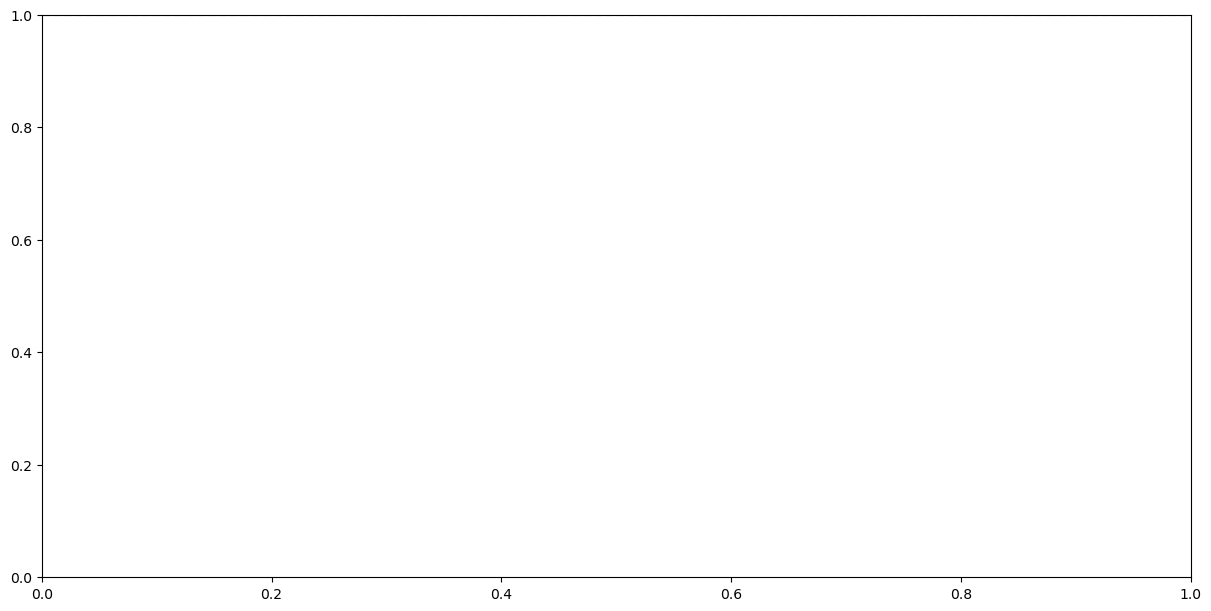

In [26]:
plot_runtime_slowdowns_of(
    results, {b for b in results["bench-size"] if b != "reference-benchmark-reference"}
)

### Performance of HiPO variants on v1 PyPSA benchmarks (also used in HiPO paper)

Run ID: `20251128-test-hipo`

In [27]:
results, variability = load_results(["../results/gcp-results/20251128-test-hipo/"])

Found 24 records, 8 benchmark instances


In [28]:
with open("../pypsa-hipo-benchmarks.yaml", "r") as f:
    hipo_benchmarks = yaml.safe_load(f)

In [29]:
# Create a speedup dataframe from the results dataframe
speedup_df = results[results["Solver"].str.contains("highs-hipo")].copy()
speedup_df = speedup_df.pivot_table(
    index="bench-size", columns="Solver", values="Runtime (s)", aggfunc="first"
).reset_index()

# Also pivot Status column
status_df = (
    results[results["Solver"].str.contains("highs-hipo")]
    .pivot_table(index="bench-size", columns="Solver", values="Status", aggfunc="first")
    .reset_index()
)

# Calculate speedups relative to ipm-time, but use status if not "ok"
speedup_df["hipo-64-speedup"] = speedup_df.apply(
    lambda row: status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo-64"
    ].values[0]
    if status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo-64"
    ].values[0]
    != "ok"
    else row["highs-hipo-ipm"] / row["highs-hipo-64"],
    axis=1,
)

speedup_df["hipo-no2hop-speedup"] = speedup_df.apply(
    lambda row: status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo-no2hop"
    ].values[0]
    if status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo-no2hop"
    ].values[0]
    != "ok"
    else row["highs-hipo-ipm"] / row["highs-hipo-no2hop"],
    axis=1,
)

# Rename columns for clarity
speedup_df = speedup_df.rename(
    columns={
        "highs-hipo-ipm": "ipm-time",
        "highs-hipo-64": "hipo-64-time",
        "highs-hipo-no2hop": "hipo-no2hop-time",
    }
)

# Add num-vars column by looking up in hipo_benchmarks
speedup_df["num-vars"] = speedup_df["bench-size"].apply(
    lambda bench_size: hipo_benchmarks["benchmarks"][bench_size]["Sizes"][0][
        "Num. variables"
    ]
)

# Format the dataframe for pretty printing
speedup_df = speedup_df.sort_values("num-vars")
display_df = pd.DataFrame(speedup_df["bench-size"])
display_df["num-vars"] = speedup_df["num-vars"].apply(lambda x: f"{x:,.0f}")
display_df["ipm-time"] = speedup_df["ipm-time"].apply(lambda x: naturaldelta(x))
display_df["hipo-64-time"] = speedup_df["hipo-64-time"].apply(lambda x: naturaldelta(x))
display_df["hipo-no2hop-time"] = speedup_df["hipo-no2hop-time"].apply(
    lambda x: naturaldelta(x)
)
display_df["hipo-64-speedup"] = speedup_df["hipo-64-speedup"].apply(
    lambda x: f"{x:.1f}x" if isinstance(x, (int, float)) else x
)
display_df["hipo-no2hop-speedup"] = speedup_df["hipo-no2hop-speedup"].apply(
    lambda x: f"{x:.1f}x" if isinstance(x, (int, float)) else x
)
display_df

KeyError: 'Num. variables'

### Performance scaling of HiPO on a PyPSA-DE benchmark
Run ID: `20251219-pypsa-sizes`

In [30]:
results, variability = load_results(["../results/gcp-results/20251219-pypsa-sizes//"])

Found 33 records, 11 benchmark instances


In [31]:
# Create a speedup dataframe from the results dataframe
speedup_df = results.pivot_table(
    index="bench-size", columns="Solver", values="Runtime (s)", aggfunc="first"
).reset_index()

# Also pivot Status column
status_df = results.pivot_table(
    index="bench-size", columns="Solver", values="Status", aggfunc="first"
).reset_index()

# Calculate speedups relative to ipm-time, but use status if not "ok"
speedup_df["ipm-speedup"] = speedup_df.apply(
    lambda row: status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-ipm"
    ].values[0]
    if status_df.loc[status_df["bench-size"] == row["bench-size"], "highs-ipm"].values[
        0
    ]
    != "ok"
    else row["highs"] / row["highs-ipm"],
    axis=1,
)

speedup_df["hipo-speedup"] = speedup_df.apply(
    lambda row: status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo"
    ].values[0]
    if status_df.loc[status_df["bench-size"] == row["bench-size"], "highs-hipo"].values[
        0
    ]
    != "ok"
    else row["highs"] / row["highs-hipo"],
    axis=1,
)

# Rename columns for clarity
speedup_df = speedup_df.rename(
    columns={
        "highs": "simplex-time",
        "highs-ipm": "ipm-time",
        "highs-hipo": "hipo-time",
    }
)

# Add num-vars column by looking up in new_pypsa_benchs
speedup_df["num-vars"] = speedup_df.apply(
    lambda row: new_pypsa_benchs.loc[
        "-".join(row["bench-size"].split("-")[:-2]), "Num. variables"
    ],
    axis=1,
)

# Format the dataframe for pretty printing
speedup_df = speedup_df.sort_values("num-vars")
display_df = pd.DataFrame(speedup_df["bench-size"])
display_df["num-vars"] = speedup_df["num-vars"].apply(lambda x: f"{x:,.0f}")
display_df["simplex-time"] = speedup_df.apply(
    lambda row: status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs"
    ].values[0]
    if status_df.loc[status_df["bench-size"] == row["bench-size"], "highs"].values[0]
    != "ok"
    else naturaldelta(row["simplex-time"]),
    axis=1,
)
display_df["ipm-time"] = speedup_df.apply(
    lambda row: status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-ipm"
    ].values[0]
    if status_df.loc[status_df["bench-size"] == row["bench-size"], "highs-ipm"].values[
        0
    ]
    != "ok"
    else naturaldelta(row["ipm-time"]),
    axis=1,
)
display_df["hipo-time"] = speedup_df.apply(
    lambda row: status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo"
    ].values[0]
    if status_df.loc[status_df["bench-size"] == row["bench-size"], "highs-hipo"].values[
        0
    ]
    != "ok"
    else naturaldelta(row["hipo-time"]),
    axis=1,
)
display_df["ipm-speedup"] = speedup_df["ipm-speedup"].apply(
    lambda x: f"{x:.1f}x" if isinstance(x, (int, float)) else x
)
display_df["hipo-speedup"] = speedup_df["hipo-speedup"].apply(
    lambda x: f"{x:.1f}x" if isinstance(x, (int, float)) else x
)
display_df
# TODO num vars

,bench-size,num-vars,simplex-time,ipm-time,hipo-time,ipm-speedup,hipo-speedup
5,pypsa-de-elec-20-24h-20-24h,"160,813",3 minutes,2 minutes,52 seconds,1.4x,3.5x
0,pypsa-de-elec-10-12h-10-12h,"176,041",2 minutes,3 minutes,54 seconds,0.5x,1.7x
3,pypsa-de-elec-20-12h-20-12h,"321,413",11 minutes,9 minutes,2 minutes,1.2x,4.4x
9,pypsa-de-elec-50-24h-50-24h,"360,415",TO,11 minutes,10 minutes,5.4x,5.9x
2,pypsa-de-elec-10-3h-10-3h,"703,831",30 minutes,33 minutes,7 minutes,0.9x,4.3x
7,pypsa-de-elec-50-12h-50-12h,"720,305",TO,50 minutes,10 minutes,1.2x,5.9x
6,pypsa-de-elec-20-3h-20-3h,"1,285,013",6 hours,2 hours,14 minutes,3.1x,26.3x
1,pypsa-de-elec-10-1h-10-1h,"2,111,271",8 hours,4 hours,36 minutes,2.1x,14.1x
10,pypsa-de-elec-50-3h-50-3h,"2,879,645",TO,TO,2 hours,TO,6.6x
4,pypsa-de-elec-20-1h-20-1h,"3,854,613",TO,TO,2 hours,TO,11.1x


### Performance of HiPO on the v2 benchmark set
Many Run IDs..

In [32]:
results, variability = load_results(
    [
        "../results/gcp-results/20251212-run-Ls/",
        "../results/gcp-results/20251214-rerun-1/",
        "../results/gcp-results/20251215-run-S-M/",
        "../results/gcp-results/20251216-rerun-2/",
        "../results/gcp-results/20251222-leftovers/",
        "../results/gcp-results/20251227-new-pypsa/",
        # '../results/partial-results/',
    ]
)

# Remove results from failed runs:
bad = {  # TODO automate from variability analysis?
    ("benchmark-instance-l-00", "20251212-run-Ls"),
    ("benchmark-instance-l-00", "20251214-rerun-1"),
    ("benchmark-instance-l-01", "20251212-run-Ls"),
    ("benchmark-instance-l-01", "20251214-rerun-1"),
    ("benchmark-instance-s-m-01", "20251215-run-S-M"),
    ("benchmark-instance-s-m-02", "20251215-run-S-M"),
    ("benchmark-instance-s-m-06", "20251215-run-S-M"),
    ("benchmark-instance-s-m-08", "20251215-run-S-M"),
    ("benchmark-instance-s-m-12", "20251215-run-S-M"),
    ("benchmark-instance-s-m-14", "20251215-run-S-M"),
}
keys = pd.MultiIndex.from_frame(results[["Hostname", "Run ID"]])
results = results.loc[~keys.isin(bad)].copy()
print(
    f"After dropping: {len(results)} records, {len(results['bench-size'].unique())} benchmark instances"
)

Found 2637 records, 169 benchmark instances
After dropping: 2312 records, 166 benchmark instances


In [33]:
benchmarks_df = load_benchmark_metadata()

In [56]:
#results

In [74]:
import pandas as pd
import numpy as np

# Load metadata
bench_meta = load_benchmark_metadata("../results/metadata.yaml")
meta = bench_meta.reset_index().rename(
    columns={"Benchmark": "Benchmark_clean", "Instance": "Size"}
)

df = final.copy()

# --- Clean benchmark column
def clean_name(row):
    b, s = row["Benchmark"], row["Size"]
    suffix = f"-{s}"
    if isinstance(b, str) and b.endswith(suffix):
        return b[: -len(suffix)]
    return b

df["Benchmark_clean"] = df.apply(clean_name, axis=1)

# --- Pivot solver runtimes → wide format
pivot = df.pivot_table(
    index=["Benchmark_clean", "Size"],
    columns="Solver",
    values="Runtime (s)",
    aggfunc="min"
).reset_index()

# --- Merge metadata
final_with_size = pivot.merge(
    meta,
    on=["Benchmark_clean", "Size"],
    how="left"
)

# Rename solver runtime columns (clean names)
final_with_size = final_with_size.rename(columns={
    "gurobi": "gurobi",
    "highs": "highs",
    "highs-hipo": "highs-hipo",
    "highs-ipm": "highs-ipm"
})

solver_cols = ["gurobi", "highs", "highs-hipo", "highs-ipm"]

# Convert runtimes to numeric and mark timeouts (86400) → NaN
for c in solver_cols:
    if c in final_with_size.columns:
        final_with_size[c] = pd.to_numeric(final_with_size[c], errors="coerce")
        final_with_size.loc[final_with_size[c] == 86400, c] = np.nan

# --- Keep only useful columns
cols_keep = ["Benchmark_clean", "Size"] + solver_cols + ["Num. variables", "Num. constraints"]
final_with_size = final_with_size[cols_keep]

# --- Sort by problem size
final_with_size = final_with_size.sort_values("Num. variables", ascending=True).reset_index(drop=True)

final_with_size


,Benchmark_clean,Size,gurobi,highs,highs-hipo,highs-ipm,Num. variables,Num. constraints
0,SWITCH-3zone-toy-stochastic-PySP,3-6ts,0.133322,0.006939,NaN,NaN,580.0,716.0
1,SWITCH-3-zone-tiny,3-6ts,0.180351,0.007130,NaN,NaN,582.0,795.0
2,SWITCH-carbon-cap,3-6ts,0.009716,0.009764,0.099950,0.021600,616.0,773.0
3,SWITCH-planning-reserves,3-6ts,0.182720,0.010473,NaN,NaN,618.0,784.0
4,SWITCH-rps-simple,3-6ts,0.158853,0.009777,NaN,NaN,618.0,777.0
5,SWITCH-3-zone-toy,3-6ts,0.138860,0.009264,NaN,NaN,618.0,775.0
6,SWITCH-hydrogen,3-6ts,0.256940,0.011648,0.112813,0.027982,733.0,863.0
7,pglib_opf_case162_ieee_dtc,162-NA,44.024007,1045.683374,NaN,NaN,742.0,1867.0
8,temoa-utopia,1-6ts,0.019104,0.019232,0.099804,0.043210,990.0,1505.0
9,SWITCH-retrofits,3-6ts,0.128381,0.040716,NaN,NaN,1310.0,1597.0


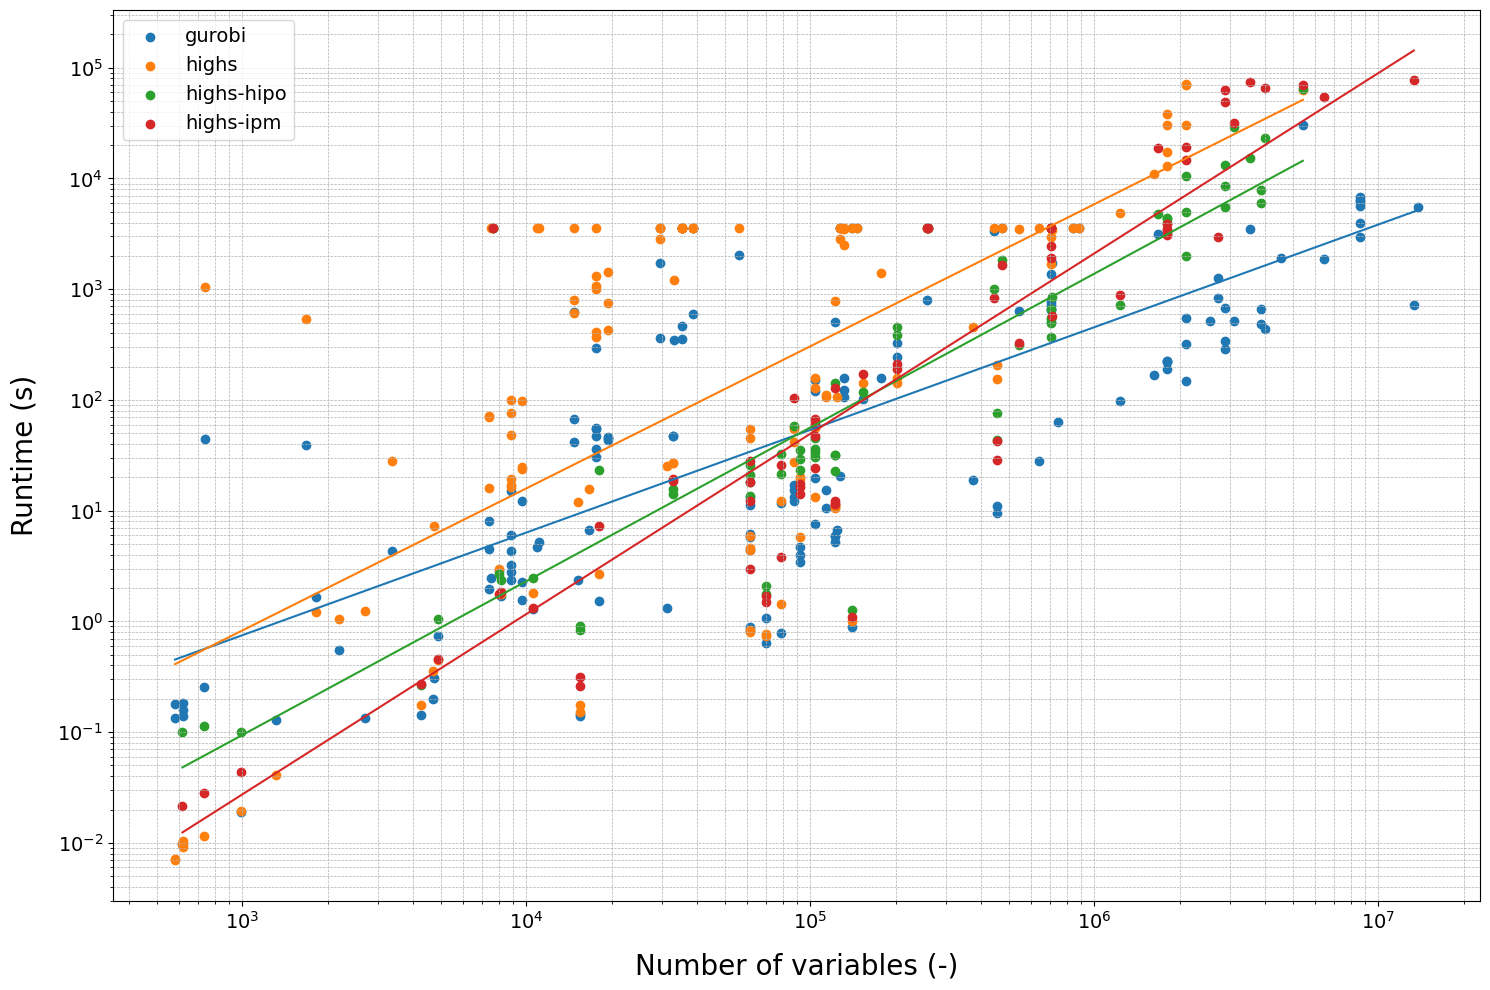

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = final_with_size.copy()
df = df[df["Num. variables"].notna()]

solvers = ["gurobi", "highs", "highs-hipo", "highs-ipm"]

for s in solvers:
    df[s] = pd.to_numeric(df[s], errors="coerce")

# Create larger figure
fig, ax = plt.subplots(figsize=(15, 10))

coeffs = {}

for s in solvers:
    sdf = df[(df[s].notna()) & (df[s] > 0) & (df["Num. variables"] > 0)]
    if sdf.empty:
        continue

    x = sdf["Num. variables"].to_numpy()
    y = sdf[s].to_numpy()

    ax.scatter(x, y, label=s)

    lx = np.log10(x)
    ly = np.log10(y)
    mask = np.isfinite(lx) & np.isfinite(ly)
    lx, ly = lx[mask], ly[mask]

    if len(lx) >= 2:
        a, b = np.polyfit(lx, ly, 1)
        coeffs[s] = a
        lx_fit = np.linspace(lx.min(), lx.max(), 100)
        y_fit = 10**(a * lx_fit + b)
        ax.plot(10**lx_fit, y_fit)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of variables (-)", fontsize=20, labelpad=14)
ax.set_ylabel("Runtime (s)", fontsize=20, labelpad=14)

# ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

# grid
ax.grid(which="both", linestyle="--", linewidth=0.5)

# legend fontsize
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()


In [34]:
# TODO
# HiPO and IPM were only run on the LPs so filter results to those
# S & M benchs were run on all years' solvers, while L was only run on latest

# Compare: HiGHS default (simplex) vs IPM vs HiPO
# Overall number of problems solved, then breakdown in each size category, model framework, etc
# SGM runtime among problems solved to get an idea of average speedup
# Largest problem solvable by each algorithm, to get an idea of how much HiPO pushes the frontier of solvable models
# Gap between HiPO and Gurobi in terms of problems solved, largest problem solvable, relative runtime on largest problems

# Are there clear recommendations in terms of when to use simplex vs IPM vs HiPO? E.g. PyPSA models, or infrastructure models?